<a href="https://colab.research.google.com/github/lapshinaaa/deep-learning-tasks/blob/main/DL5_transformers_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Transformers for Named Entity Recognition`

## 🧩 What You Will Learn in This Assignment

In this assignment, you will practice modern NLP tooling and learn how to:

1. Load datasets and pretrained models from the [Hugging Face Hub](https://huggingface.co)  
2. Manipulate text datasets using the [`datasets`](https://huggingface.co/docs/datasets/index) library  
3. Run and fine-tune transformers with the [`transformers`](https://huggingface.co/docs/transformers/index) library  
4. Prompt a large language model, using [Qwen2.5-7B-Instruct](https://huggingface.co/Qwen/Qwen2.5-7B-Instruct) as an example  
5. Optimize hyperparameters using [Optuna](https://optuna.org/)  

---

## 🎯 Task Overview  

You will work on a standard token classification task:  
Named Entity Recognition (NER).

The assignment is divided into three parts:

1. Data preparation and working with datasets from Hugging Face  
2. Large Language Model prompting  
3. Fine-tuning a transformer model

---

## 📚 Recommended Reading

Make sure to study the official guide on token classification:  
👉 https://huggingface.co/learn/nlp-course/chapter7/2

---

## 🔧 Notes

Wherever the assignment instructs you to use *wandb*, you may use any unblocked alternatives.

## `Part I. Loading and preprocessing`

### `Google Colab environment preparation`

Secrets in colab:

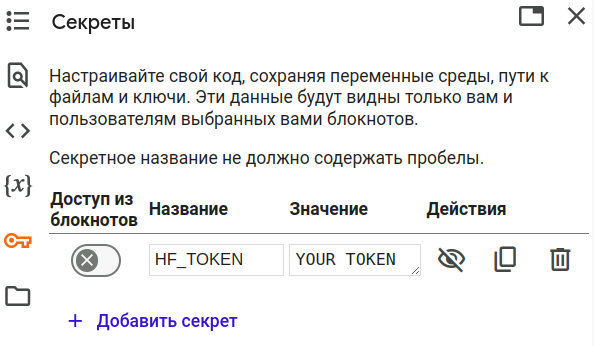

### `General Preprocessing`

In [1]:
# pip offers the --quiet / -q option to silence output

! pip install transformers[torch] datasets autoawq evaluate seqeval optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 22.6 MB/s eta 0:00:00


In [2]:
!pip freeze > requirements.txt
!cat requirements.txt | grep torch

torch==2.9.0+cu126
torchao==0.10.0
torchaudio==2.9.0+cu126
torchdata==0.11.0
torchsummary==1.5.1
torchtune==0.6.1
torchvision==0.24.0+cu126


In [3]:
!cat requirements.txt | grep transformers
!cat requirements.txt | grep datasets
!cat requirements.txt | grep autoawq
!cat requirements.txt | grep evaluate
!cat requirements.txt | grep seqeval
!cat requirements.txt | grep optuna

sentence-transformers==5.1.2
transformers==4.57.2
datasets==4.0.0
tensorflow-datasets==4.9.9
vega-datasets==0.9.0
autoawq==0.2.9
evaluate==0.4.6
seqeval==1.2.2
optuna==4.6.0


In [4]:
import gc
import json
import random
from typing import Any, Union
from pathlib import Path
from collections import Counter

import numpy as np
import numpy.typing as npt

import torch
import datasets
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TextGenerationPipeline,
    pipeline,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from transformers.trainer_callback import EarlyStoppingCallback

import optuna
import evaluate

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [5]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def print_params_count(model):

    total_params = sum(p.numel() for p in model.parameters())
    total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)

    model_name = model.__class__.__name__
    print(f"Info about the number of model parameters: {model_name}")
    print(f"Overall params: \t\t {total_params}")
    print(f"Trainable params: \t {total_params_grad}")
    print()

set_global_seed(42)

In [6]:
if not torch.cuda.is_available():
    print("You need GPU!!!")

### `Loading Data`

First of all, Hugging Face --- is a hub with ready-to-use models and datasets. Upload a dataset [from here](https://huggingface.co/datasets/voorhs/conll2003-corrupted).

Tip: read [tutorial](https://huggingface.co/docs/datasets/load_hub).

In [14]:
from datasets import load_dataset

dataset = load_dataset("voorhs/conll2003-corrupted")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/309k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/281k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

**Question**: What fields are available to us? Print out a couple examples from each split. Try and guess what meaning each field has and describe it in two words.

*Tip:* read [tutorial](https://huggingface.co/docs/datasets/access).

In [16]:
dataset['train'][0]

{'id': '473',
 'tokens': ['LONDON', '1996-08-22'],
 'pos_tags': [22, 11],
 'chunk_tags': [11, 12],
 'ner_tags': ['B-LOC', 'O']}

In [17]:
dataset['validation'][2]

{'id': '2',
 'tokens': ['West',
  'Indian',
  'all-rounder',
  'Phil',
  'Simmons',
  'took',
  'four',
  'for',
  '38',
  'on',
  'Friday',
  'as',
  'Leicestershire',
  'beat',
  'Somerset',
  'by',
  'an',
  'innings',
  'and',
  '39',
  'runs',
  'in',
  'two',
  'days',
  'to',
  'take',
  'over',
  'at',
  'the',
  'head',
  'of',
  'the',
  'county',
  'championship',
  '.'],
 'pos_tags': [22,
  22,
  21,
  22,
  22,
  38,
  11,
  15,
  11,
  15,
  22,
  15,
  22,
  38,
  22,
  15,
  12,
  21,
  10,
  11,
  24,
  15,
  11,
  24,
  35,
  37,
  15,
  15,
  12,
  21,
  15,
  12,
  21,
  21,
  7],
 'chunk_tags': [11,
  12,
  12,
  12,
  12,
  21,
  11,
  13,
  11,
  13,
  11,
  13,
  11,
  21,
  11,
  13,
  11,
  12,
  0,
  11,
  12,
  13,
  11,
  12,
  21,
  22,
  13,
  13,
  11,
  12,
  13,
  11,
  12,
  12,
  0],
 'ner_tags': ['B-MISC',
  'I-MISC',
  'O',
  'B-PER',
  'I-PER',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-ORG',
  'O',
  'B-ORG',
  'O',
  'O',
  'O',
  'O'

In [13]:
dataset['test'][3]

{'id': '3',
 'tokens': ['Japan',
  'began',
  'the',
  'defence',
  'of',
  'their',
  'Asian',
  'Cup',
  'title',
  'with',
  'a',
  'lucky',
  '2-1',
  'win',
  'against',
  'Syria',
  'in',
  'a',
  'Group',
  'C',
  'championship',
  'match',
  'on',
  'Friday',
  '.'],
 'pos_tags': [22,
  38,
  12,
  21,
  15,
  29,
  16,
  22,
  21,
  15,
  12,
  16,
  11,
  41,
  15,
  22,
  15,
  12,
  22,
  22,
  21,
  21,
  15,
  22,
  7],
 'chunk_tags': [11,
  21,
  11,
  12,
  13,
  11,
  12,
  12,
  12,
  13,
  11,
  12,
  12,
  21,
  13,
  11,
  13,
  11,
  12,
  12,
  12,
  12,
  13,
  11,
  0],
 'ner_tags': ['B-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-MISC',
  'I-MISC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']}

**Answer:**

### Dataset Fields Meaning

| Field        | Description                                                                 | Two-word summary |
|--------------|------------------------------------------------------------------------------|------------------|
| id         | Unique identifier of the sentence.                                           | sentence id      |
| tokens     | List of words in the sentence.                                               | word sequence    |
| pos_tags   | Part-of-speech tags encoded as integers.                                     | POS tags         |
| chunk_tags | Syntactic phrase/chunk labels encoded as integers (NP, VP, PP…).             | chunk labels     |
| ner_tags   | Named-entity labels in IOB2 format (e.g., B-LOC, I-MISC, O).                 | entity labels    |

### `Column Removal`

We will be predicting NER tags directly based on text. The remaining information is not needed. Remove all columns except `tokens` and `ner_tags`.

*Tip:* read [tutorial](https://huggingface.co/docs/datasets/process#remove).

In [18]:
dataset = dataset.remove_columns(["id", "pos_tags", "chunk_tags"])
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
# YOUR CODE IS HERE

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

### `Collecting Tags (NER Label Exploration)`

Note that the dataset uses BIO-tagging.

BIO-tagging is a common annotation scheme for Named Entity Recognition (NER):
- B — *Beginning* of an entity  
- I — *Inside* the same entity  
- O — *Outside* (not part of any entity)

Examples:

- Sentence: *"Apple выпустила новый iPhone"*  
  BIO tags:  
  Apple/B-ORG выпустила/O новый/O iPhone/B-PRODUCT

- Sentence: *"Билл Гейтс основал Microsoft"*  
  BIO tags:  
  Билл/B-PER Гейтс/I-PER основал/O Microsoft/B-ORG

This format helps the model identify entity boundaries and types.

---

### Task

Before working with the dataset, we need to understand which NER tags are present.

Print all unique NER tag values found across the dataset.

*Hint:*  
You can iterate over a Hugging Face dataset using a usual for ... in ... loop.

---

### Question

Are there any suspicious tags that should not be present?

In [19]:
unique_NER_tags = set() # for storing unique tags

In [20]:
for split_name, split in dataset.items():
  for field in split:
    for tag in field['ner_tags']:
      unique_NER_tags.add(tag)

In [21]:
unique_NER_tags

{'B-LOC',
 'B-MISC',
 'B-ORG',
 'B-PER',
 'I-LOC',
 'I-MISC',
 'I-ORG',
 'I-PER',
 'MISSING',
 'O'}

Or we can do it using a Counter

In [13]:
tag_counter = Counter()

for split_name, split in dataset.items():
    for row in split:
        tag_counter.update(row["ner_tags"])

print("NER tags and their frequencies:")
for tag, count in tag_counter.most_common():
    print(f"{tag:10s}  →  {count}")

NER tags and their frequencies:
O           →  201830
MISSING     →  58634
B-LOC       →  8561
B-PER       →  8127
B-ORG       →  7550
I-PER       →  5677
I-ORG       →  4287
B-MISC      →  4044
I-MISC      →  1355
I-LOC       →  1353


There is a "suspicious" tag: "MISSING" --> we will remove it

For loss and metric calculation we will need to turn tags into classes, since we'll be solving a classification problem.

Create tag mapping:
- `label2id`: string of a class (for example `B-PER`) -> index of this class
- `id2label`: vice versa

Remove suspicious tags.

*Tip:* there have to be 9 tags remaining

In [22]:
valid_tags = sorted([tag for tag in unique_NER_tags if tag != "MISSING"])

In [18]:
valid_tags

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [23]:
id2label = valid_tags
id2label

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [ ]:
# YOUR CODE IS HERE

id2label

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [24]:
label2id = {label: i for i, label in enumerate(id2label)}
label2id

{'B-LOC': 0,
 'B-MISC': 1,
 'B-ORG': 2,
 'B-PER': 3,
 'I-LOC': 4,
 'I-MISC': 5,
 'I-ORG': 6,
 'I-PER': 7,
 'O': 8}

### `Filtering`

In the training part of the dataset for a portion of objects (data) isn't annotated. Split the training part into annotated and non-annotated objects. Print out the size of both of these portions.

*Tip:* read [tutorial](https://huggingface.co/docs/datasets/process#select-and-filter). Filtering can be done in one line.

In [21]:
train_missing = dataset['train'].filter(lambda x: "MISSING" in x['ner_tags'])
train_full = dataset['train'].filter(lambda x: "MISSING" not in x['ner_tags'])

len(train_missing)

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

4041

In [22]:
# YOUR CODE IS HERE
dataset_raw_essential = {}
dataset_raw_essential["train_missing"] = train_missing
dataset_raw_essential["train"] = train_full

dataset_raw_essential

{'train_missing': Dataset({
     features: ['tokens', 'ner_tags'],
     num_rows: 4041
 }),
 'train': Dataset({
     features: ['tokens', 'ner_tags'],
     num_rows: 10000
 })}

In [23]:
assert len(dataset_raw_essential["train_missing"]) == 4041

### `Getting tokenizer-independent representation`

## Tokenizer-Independent Representation

The existing BIO annotation was produced using a tokenizer that is unknown to us.  
Therefore, we must build a tokenizer-independent representation of the dataset.

---

### 1. Reconstructing Text

For each dataset entry, you must join tokens from the field tokens into a single string and store it in field text.

Rules for spacing:

- punctuation marks, quotes, and parentheses  
  (`,`, ., !, ?, ), ", `'`)  
  must NOT have a space *before* them,  
  but must have a space *after* them.

Example:
- "Hello , world !" ❌ wrong  
- "Hello, world!" ✔ correct  
- "word ) next" ❌ wrong  
- "word) next" ✔ correct

---

### 2. Converting BIO Annotation

Since every tokenizer will split text differently, we need to build a representation of named entities that does not depend on tokenization.

Using the existing BIO tags:

1. Remove BIO prefixes (drop B- and `I-`), keeping only entity types  
   (PER, ORG, LOC, etc.)

2. For each named entity, determine the character-span in text  
   using Python slice format — [start, end].

---

### Example Output

```python
{
    'text': '6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)',
    'tags': ['PER', 'LOC', 'PER', 'LOC'],
    'ranges': [[4, 16], [19, 23], [30, 44], [47, 55]]
}
```

Explanation:

In the text
'6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)'
there are four named entities:

 • PER at positions [4, 16] → "Andre Agassi"

 • LOC at positions [19, 23] → "U.S."

 • PER at positions [30, 44] → "Mauricio Hadad"

 • LOC at positions [47, 55] → "Colombia"

⸻

# Important

 • Save the transformed dataset to disk (e.g., ./data/generic)

 • Refer to the docstring of transform_ner_data for precise argument names and expected return values

In [24]:
def transform_ner_data(tokens: list[str], ner_tags: list[str]):
    """
    Obtain tokenizer-independent representation of a single sample.

    Args:
        tokens: list of words, subwords or even punctuations
        ner_tags: list of BIO labels
    Returns:
        sample: dictionary with the following contents:
            - text (str): detokenized sequence
            - tags (list[str]): list of tags names (PER, ORG, LOC, MISC)
            - ranges (list[tuple[int, int]]): list of python slices for each entity
    """

    punctuation_symbols = ("-", "'", ".", ",", ")", ":", ";", '"')

    text = ""
    ranges = []
    tags = []

    # declare vars if you needed
    # YOUR CODE IS HERE

    curr_tag = None
    start_idx = None

    for token, tag in zip(tokens, ner_tags):
        # Adjust spacing based on token type
        if len(text) > 0 and not token.startswith(
            punctuation_symbols
        ):
            text += " "

        token_start = len(text)
        text += token
        token_end = len(text)

        # Handle entity tagging
        if tag.startswith("B-"):  # Begin a new entity
            # Close the previous entity if it was open
            if curr_tag is not None:
              tags.append(curr_tag)
              ranges.append([start_idx, prev_end])

            # start new entity (we just closed the previous one)
            curr_tag = tag[2:] # remove B-
            start_idx = token_start

        elif tag.startswith("I-"):  # Continue an entity
            # YOUR CODE IS HERE
            ent_type = tag[2:]

            # but if it doesn't match curr entity, we are starting a new one
            if curr_tag is None or ent_type != curr_tag:
              if curr_tag is not None:
                tags.append(curr_tag)
                ranges.append([start_idx, prev_end])

              # start new entity (we just closed the previous one)
              curr_tag = tag[2:] # remove B-
              start_idx = token_start


        else:  # Tag is "O" or unrelated, close any open entity
            # YOUR CODE IS HERE
            if curr_tag is not None:
              tags.append(curr_tag)
              ranges.append([start_idx, prev_end])
              curr_tag = None
              start_idx = None

        prev_end = token_end

    # Close any open entity at the end
    # YOUR CODE IS HERE
    if curr_tag is not None:
      tags.append(curr_tag)
      ranges.append([start_idx, prev_end])

    # Final output
    return {"text": text, "tags": tags, "ranges": ranges}

Make sure that everything works fine:

In [32]:
from datasets import DatasetDict

dataset_raw_essential = DatasetDict({
    "train": train_full,
    "train_missing": train_missing,
    "validation": dataset["validation"],
    "test": dataset["test"],
})

In [33]:
dataset_raw_essential

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 10000
    })
    train_missing: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 4041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

In [34]:
dataset_generic = dataset_raw_essential.map(
    function=transform_ner_data,
    input_columns=["tokens", "ner_tags"],
    remove_columns=dataset_raw_essential["train"].column_names,
)

dataset_generic

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
})

In [35]:
assert dataset_generic["train"][:3] == {
    "text": [
        "LONDON 1996-08-22",
        "WorldCom, which said it will buy MFS, shed 1-3/4 to close at 21 while MFS lost 3-8/16 to close at 41-5/16.",
        "6- Andre Agassi ( U.S.) vs. Mauricio Hadad ( Colombia)",
    ],
    "tags": [["LOC"], ["ORG", "ORG", "ORG"], ["PER", "LOC", "PER", "LOC"]],
    "ranges": [
        [[0, 6]],
        [[0, 8], [33, 36], [70, 73]],
        [[3, 15], [18, 22], [28, 42], [45, 53]],
    ],
}

Save the result to the disk (use functions from library `datasets`):

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
dataset_generic.save_to_disk('/content/drive/MyDrive/DL2/data')

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

In [8]:
# loading the dataset
from datasets import *
dataset_generic = load_from_disk('/content/drive/MyDrive/DL2/data')

### `Tokenization`

We'll be using the following tokenizer of the model `google-bert/bert-base-uncased`.

In [9]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [10]:
print(bert_tokenizer(dataset_generic["train"]["text"][11]))

{'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Each tokenizer has its own special tokens. For getting this information the following variable can be used


In [11]:
bert_tokenizer.all_special_ids

[100, 102, 0, 101, 103]

Now we need to write a function that, based on the existing tokenizer-independent representation, produces a BIO annotation aligned to the tokens of a provided tokenizer.

Implement the function `align_tokens_and_tags`, which transforms a single sample from the dataset.
All details about input/output format should be taken from the function’s docstring.

Important:
Special tokens added by the tokenizer must receive the label `SPECIAL_TOKENS_LABEL`, because they should NOT be included when computing the loss.

In [ ]:
SPECIAL_TOKENS_LABEL = -100


def align_tokens_and_tags(
    text: str, tags: list[str], ranges: list[tuple[int, int]], tokenizer: AutoTokenizer
):
    """
    Align the tokenizer-independent representation with a Hugging Face tokenizer.

    Args:
        text: original text.
        tags: list of entity tags (e.g., ["PER", "LOC"]).
        ranges: list of (start, end) character ranges for each entity.
        tokenizer: A Hugging Face tokenizer.

    Returns:
        dict: A dictionary with `input_ids`, `labels`:
            - input_ids are tokens indices in tokenizer's vocabulary
            - labels are integer labels for BIO tags (from label2id mapping)

    Note:
        This function
    """
    encoding = tokenizer(
        text, return_offsets_mapping=True, truncation=True, padding=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    token_ids = encoding["input_ids"]
    offset_mapping = encoding["offset_mapping"]


    # Initialize BIO tags for each token
    # YOUR CODE IS HERE
    labels=[]
    for token_id, (start, end) in zip(token_ids, offset_mapping):
      if token_id in tokenizer.all_special_ids:
        labels.append(SPECIAL_TOKENS_LABEL)
      else:
        labels.append(label2id["O"])

    # Map character ranges to token indices
    for tag, (start, end) in zip(tags, ranges):
        # Find tokens that overlap with the entity range
        for (i, (token_start, token_end)), token_id in zip(
            enumerate(offset_mapping), token_ids
        ):

            # detect no overlap
            # YOUR CODE IS HERE
            if token_end <= start or token_start >= end:
              continue # skip if no overlap
            # same for special tokens
            if token_id in tokenizer.all_special_ids:
              continue

            # classifier token
            #     hint: use if
            # YOUR CODE IS HERE


    return {
        "input_ids": ...,
        "labels": ... # don't forget to handle special tokens
    }

In [ ]:
def tokenize_ner_dataset(
    dataset: Union[datasets.DatasetDict, datasets.Dataset], tokenizer: AutoTokenizer
):
    return dataset.map(
        function=align_tokens_and_tags,
        input_columns=["text", "tags", "ranges"],
        fn_kwargs={"tokenizer": tokenizer},
        remove_columns=(
            dataset["train"] if "train" in dataset else dataset
        ).column_names,
    )

A few examples of what we should be getting:

In [ ]:
for i in range(9, 12):
    sample = dataset_generic["train"][i]
    print("before tokenization:", sample)
    tokenized_sample = align_tokens_and_tags(**sample, tokenizer=bert_tokenizer)
    print("after tokenization:", tokenized_sample)
    print()

before tokenization: {'text': '1-0.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 1015, 1011, 1014, 1012, 102], 'labels': [-100, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Puchon 3 Chonan 0 ( halftime 1-0)', 'tags': ['ORG', 'ORG'], 'ranges': [[0, 6], [9, 15]]}
after tokenization: {'input_ids': [101, 16405, 24561, 1017, 16480, 7229, 1014, 1006, 22589, 1015, 1011, 1014, 1007, 102], 'labels': [-100, 2, 6, 8, 2, 6, 8, 8, 8, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Primary iron output was 297,700 tonnes, 14.5 percent more than last July and 0.1 percent more than in June.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'labels': [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100]}



Tests:

In [ ]:
dataset_tokenized = tokenize_ner_dataset(dataset_generic, bert_tokenizer)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

In [ ]:
assert dataset_tokenized["train"][5:7] == {
    "input_ids": [
        [
            101,
            2002,
            2596,
            2000,
            2031,
            2042,
            2730,
            2006,
            9857,
            2305,
            1010,
            6114,
            2012,
            2560,
            2809,
            17079,
            8710,
            1012,
            102,
        ],
        [
            101,
            1023,
            1012,
            13093,
            6178,
            25185,
            1006,
            5706,
            1007,
            8902,
            4877,
            13181,
            2361,
            3590,
            102,
        ],
    ],
    "labels": [
        [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100],
        [-100, 8, 8, 3, 7, 7, 8, 0, 8, 2, 6, 6, 6, 8, -100],
    ],
}

## `Часть 2. Доразметка с помощью LLM (2 балла)`

Наконец, обратимся к трансфомерам! Причем сразу к большим.

Мы воспользуемся моделью `Qwen2.5` на 7 миллиардов параметров. Посмотреть актуальный лидерборд различных LLM [можно тут](https://lmarena.ai/). Кроме того, во вкладке direct chat можно пообщаться с различными LLM бесплатно.

### `Промт инжиниринг`

Для удобства парсинга, мы будем просить LLM возвращать ответы сразу в формате `json` словаря.

Напишите промт, в котором перечислите и опишите поля словаря, которые вы хотите получать от LLM.

**Важно:** скорее всего, вы будете возвращаться к этому заданию и редактировать промт, чтобы улучшить качество дальшейших шагов.

*Подсказка:* попросите LLM добавить в словарь отдельное поле `reasoning`, в которую она поместит рассуждения

In [ ]:
def messages_maker(text: str) -> list[dict[str, str]]:
    """
    Creates a prompt for the LLM inference to generate NER labels.

    Args:
        text: The input text to be labeled.
    Returns:
        list: A list of messages formatted for the LLM inferemce.
    """
    system_message = (
        "You are an expert in Named Entity Recognition (NER). Your task is to analyze the given text and identify "
        "entities such as persons (PER), locations (LOC), organizations (ORG), and miscellaneous (MISC). "
        "You must return the results in a specific JSON format with the following fields: "
        "The 'reasoning' field should contain all your initial thoughts for solving NER task. "
        ##############
        # YOUR PROMPT
        ...
        ##############
    )

    user_message = f"Please analyze the following text and generate the NER labels as described:\n\n{text}"

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message},
    ]

    return messages

Для обработки одного примера будем использовать функцию `generate_answer`.

**Важно:** чтобы понимать, как это работает, почитайте [туториал](https://huggingface.co/docs/transformers/main/en/conversations#textgenerationpipeline).

In [ ]:
def generate_answer(generator: TextGenerationPipeline, query: str) -> str:
    chat = generator(messages_maker(query), max_new_tokens=1024)[0]["generated_text"]
    return chat[-1]["content"]

Эта функция отправляет текстовый запрос `query` большой языковой модели и возвращает ответ:

In [ ]:
from transformers import pipeline


model_name = "Qwen/Qwen2.5-7B-Instruct-AWQ"

generator = pipeline(model=model_name, task="text-generation", device="cuda")
print(type(generator))

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda


<class 'transformers.pipelines.text_generation.TextGenerationPipeline'>


In [ ]:
print_params_count(generator.model)

Информация о числе параметров модели: Qwen2ForCausalLM
Всего параметров: 		 1090199040
Всего обучаемых параметров: 	 1090199040



In [ ]:
generate_answer(generator, "I live in London, but my father is from Germany.")

In [ ]:
generate_answer(generator, "Can't wait the Oasis reunion.")

In [ ]:
generate_answer(generator, "Check, please.")

In [ ]:
generate_answer(generator, "Сигма сигма боой сигма боой сигма бой.")

### `Валидация ответов LLM (0.5 балла)`

Ответы LLM не всегда точны. Часто она галлюцинирует или просто делает не то, о чем ее попросили. Поэтому для удобной автоматизации работы с LLM важно уметь валидировать ответы.

1. Проанализируйте ответы LLM из предыдущих ячеек с вызовом `generate_answer` и предположите какие ошибки может делать LLM при генерации ответа.

2. Напишите валидатор, которые будет проверять корректность ответа LLM.

**Вопросы:**
- Какие ошибки LLM можно простить?
- Приведите примеры ошибок (и валидных семплов) и продемонстрируйте работу вашего валидатора

**Важно:** скорее всего, вы будете возвращаться к этому заданию и редактировать промт, чтобы улучшить качество дальшейших шагов.

In [ ]:
def validate(answer: dict) -> None:
    """
    Validate answer from LLM.

    Args:
        answer: dictionary parsed from LLM output

    Raises:
        ValueError: if the answer is not valid
    """
    # YOUR CODE IS HERE
    #    hint: raise ValueError(error message)
    ...

### `Обработка ответа LLM (1.5 балла)`

Напишите функцию `generate_ner_labeling`, которая для данного примера
- обращается к LLM чтобы получить разметку (с помощью функции `generate_answer`, определенной ранее)
- парсит ответ LLM в питоновский словарь (с помощью функции `parse`, см. ниже)
- валидирует словарь (с помощью функции `validate`, определенной ранее)
- делает `k_tries` попыток, пока LLM не выдаст валидный ответ

**Важно:** для простоты считайте что в одном тексте одна и та же сущность не повторяется (т.е. "i work at apple and eat an apple" нет в датасете).

*Подсказка:*
- пользуйтесь конструкцией `try except`

Уделите особое внимание следующему вопросу:
- как лучше всего получать `ranges`: просить LLM или пытаться сделать самому?

In [ ]:
def parse(response: str) -> dict[str, Any]:
    """
    Parse LLM's response into dictionary.

    Returns:
        out: dictionary with the arbitrary keys
    """
    start_dict = response.find("{")
    end_dict   = len(response) - response[::-1].find("}") - 1
    return json.loads(response[start_dict : end_dict + 1])

In [ ]:
def generate_ner_labeling(
    text: str, generator: TextGenerationPipeline, k_tries: int = 3
) -> dict:
    """
    Generates NER labeling for the given text using the provided LLM instance.

    Args:
        text: The input text to label.
        llm: The LLM instance for generating NER labels.
        k_tries: Maximum number of attempts to generate valid JSON.

    Returns:
        A dictionary containing 'text', 'tags', 'ranges', 'reasoning' if managed to generate valid samples,
            otherwise dict with 'tags', 'ranges', 'reasoning' are filled with None.
    """
    for _ in range(k_tries):
        try:
            # YOUR CODE IS HERE
            ...
            return result

        except (json.JSONDecodeError, ValueError) as e:
            print(
                f"Invalid JSON or validation error: {e}. Response: {response}. Retrying..."
            )
            continue

        finally:
            gc.collect()
            torch.cuda.empty_cache()

    # YOUR CODE IS HERE
    print(f"Failed to generate valid NER labeling after {k_tries} attempts.")
    return ...

Хороший результат должен выглядеть подобным образом:

In [ ]:
generate_ner_labeling("I live in London but my dog Jack doesn't like it.", generator)

Successful generation!


{'reasoning': "In this text, we need to identify any named entities such as persons, locations, or organizations. The text mentions 'London', which is a location. 'Jack' is mentioned as a dog's name, so it does not fit into any of the specified categories and would be classified as MISC.",
 'text': "I live in London but my dog Jack doesn't like it.",
 'tags': ['LOC', 'MISC'],
 'ranges': [[10, 16], [28, 32]]}

Загрузите из памяти ранее рагруженный датасет в tokenizer-independent представлении.

In [ ]:
# YOUR CODE IS HERE


Dataset({
    features: ['text', 'tags', 'ranges'],
    num_rows: 4041
})

Мы не можем полноценно разметить 4000+ примеров. Работа LLM на потребительском железе и особенно в облачных средах типа Google Colab и Kaggle очень медленная.

В качестве щадящего режима авторы задания предлагают сделать следующее: доразметить только 10 примеров в пределах от 15 до 30 символов.

In [ ]:
subset_size = 10
min_chars = 15
max_chars = 30
# YOUR CODE IS HERE
...

Filter:   0%|          | 0/4041 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'tags', 'ranges'],
    num_rows: 10
})

Приступим к синтезированию!

In [ ]:
synthetic = [generate_ner_labeling(sample["text"], generator) for sample in dataset]

Successful generation!
Successful generation!
Successful generation!
Successful generation!
Successful generation!


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Successful generation!
Successful generation!
Successful generation!
Successful generation!
Successful generation!


Хороший результат должен быть примерно таким:

In [ ]:
synthetic

[{'reasoning': "The text provided is short, but it contains a location-related term 'International' which can refer to international reserves held by central banks across various countries. However, without more context, it's difficult to pinpoint a specific country or organization. Therefore, we will label 'International' as LOC since it refers to a global context rather than a specific place or organization.",
  'text': 'International reserves and',
  'tags': ['LOC'],
  'ranges': [[0, 13]]},
 {'reasoning': 'The text contains a location (MINNESOTA) and some numerical values (65, 65.500). Since MINNESOTA is a state, it falls under the LOC category. The numbers do not represent any named entities but are likely part of statistics or scores.',
  'text': 'MINNESOTA 65 65.500 12',
  'tags': ['LOC'],
  'ranges': [[0, 9]]},
 {'reasoning': 'The text contains a location (LONDON) and a date (1996-08-28). The date does not fall into any of the specified categories (PER, ORG, LOC), so it will be 

Результат присоедините к трейновой части нашего `generic` датасета и сохраните результат в папке `generic-synthetic`.

**Важно:** не забудьте отфильтровать неудачные результаты генерации, если они есть (это про случаи когда `k_tries` исчерпались)

In [ ]:
# YOUR CODE IS HERE
...

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10010 [00:00<?, ? examples/s]

Дальше мы не будем использовать генератор, поэтому нам нужно освободить память. Код ниже удалит модельку из памяти:

In [ ]:
del generator
gc.collect()
torch.cuda.empty_cache()

## `Часть 3. Дообучение модели (4 балла)`

Приступим к дообучению модели. Кажется, что наступает самая сложная часть? Действительно, нам предстоит реализовать следующее:
- подсчет лосс функции для каждого токена
- подсчет метрик точности классификации
- встроить это в цикл обучения
- настроить правильное логирование и сохранение чекпоинтов
- желательно подобрать гиперпараметры

На самом деле все просто! `transformers` позволяет реализовать это в два счета благодаря использованию следующих сущностей (все в списке это ссылки на документацию):
- автомодель `AutoModelForTokenClassification` ([документация тут](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForTokenClassification))
- библиотека `evaluate` ([документация тут](https://huggingface.co/docs/evaluate/index))
- класс `DataCollatorForTokenClassification` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/data_collator#transformers.DataCollatorForTokenClassification))
- интеграция с `optuna` ([документация тут](https://optuna.org/))
- и самое главное, Trainer API в лице `Trainer` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer)) и `TrainingArguments` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments))

### `Токенизация датасета (0.1 балла)`

Токенизируйте датасет с помощью токенизатора модели `BAAI/bge-small-en-v1.5` [документация тут](https://huggingface.co/BAAI/bge-small-en-v1.5) и ранее написанной функции `tokenize_ner_dataset`.

In [ ]:
from transformers import AutoTokenizer

model_name = "BAAI/bge-small-en-v1.5"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Загрузите датасет с диска.

In [ ]:
# YOUR CODE IS HERE


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4041
    })
})

### `Коллатор (0.1 балла)`

Инициализируйте коллатор и продемонстрируйте его работу.

In [ ]:
# YOUR CODE IS HERE
...

In [ ]:
batch = collator([tokenized_dataset["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    0,    8,    8,    8,    8,    8, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100],
        [-100,    2,    6,    8,    8,    8,    8,    8,    8,    2,    6,    8,
            8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    2,
            6,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,
            8,    8,    8,    8, -100]])

### `Метрики (0.8 балла)`

Библиотека `evaluate` ([документация тут](https://huggingface.co/docs/evaluate/index)) предоставляет набор популярных метрик для NLP. Метрики для `NER` можно загрузить следующей командой:

In [ ]:
import evaluate

metric = evaluate.load("seqeval")

Эта метрика работает с BIO разметкой в текстовом представлении:

In [ ]:
metric.compute(
    predictions=[["O", "B-PER", "O", "O"]], references=[["O", "B-PER", "I-PER", "O"]]
)

{'PER': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(0.0),
 'overall_recall': np.float64(0.0),
 'overall_f1': np.float64(0.0),
 'overall_accuracy': 0.75}

In [ ]:
metric.compute(
    predictions=[["O", "B-PER", "B-ORG", "O"]],
    references=[["O", "B-PER", "I-PER", "B-ORG"]],
)

{'ORG': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'PER': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(0.0),
 'overall_recall': np.float64(0.0),
 'overall_f1': np.float64(0.0),
 'overall_accuracy': 0.5}

Реализуйте функцию `compute_metrics`.

In [ ]:
def compute_metrics(
    eval_preds: tuple[npt.NDArray, list[list[int]]],
) -> dict[str, float]:
    """
    Compute metrics on given batch.

    Args:
        eval_preds: tuple with the following contents:
            - logits: array of shape `(batch_size, seq_length, n_classes)`,
            - labels: list of lists, i.e. matrix of shape `(batch_size, seq_length)`
    Returns:
        metrics: dictionary with metrics calculated over all classes:
            - precision
            - recall
            - f1
            - accuracy
    """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # YOUR CODE IS HERE

    # Remove ignored index (special tokens) and convert to labels
    ...

    all_metrics = metric.compute(...)

    return {
        "precision": ...,
        "recall": ...,
        "f1": ...,
        "accuracy": ...,
    }

### `Построение модели`

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обратите внимание на её структуру --- `transformers` автоматически добавил `classifier` с нужным числом классов:

In [ ]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12

In [ ]:
print_params_count(model)

Информация о числе параметров модели: BertForTokenClassification
Всего параметров: 		 33215625
Всего обучаемых параметров: 	 33215625



### `Обучение (1 балл)`

Ниже представлен базовый код для обучения модели:

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 3145tttt to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.222000,0.140657,0.788677,0.841636,0.814296,0.968570
2,0.111300,0.103507,0.839381,0.875968,0.857284,0.975139
3,0.082200,0.096619,0.844141,0.885056,0.864114,0.976104


TrainOutput(global_step=3750, training_loss=0.17989798075358074, metrics={'train_runtime': 212.8129, 'train_samples_per_second': 140.969, 'train_steps_per_second': 17.621, 'total_flos': 158919761119392.0, 'train_loss': 0.17989798075358074, 'epoch': 3.0})

Благодаря простому интерфейсу обучения разработчик может сместить фокус своих усилий с написания трейн лупа на решение более высокоуровневых задач.

Модифицируйте `Trainer` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer)) и `TrainingArguments`([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments)) следующим образом:
- должно происходить логирование в `wandb`
- должен срабатывать ранний останов обучения, если качество перестало расти (подберите параметры на ваше усмотрение)
- лучший чекпоинт загружается в публичный репозиторий на `hugging face hub`

Добавьте в ячейку ниже ссылку на свой `wandb` отчет и ссылку на свой репозиторий `hugging face hub`.

- **Отчет wandb**: *your link*
- **Репозиторий hf**: *your link*

In [ ]:
# YOUR CODE IS HERE

### `Перебор гиперпараметров (1 балл)`

Trainer API обладает интеграцией с `optuna` -- инструментом для перебора гиперпараметров в машинном обучении. Реализуйте перебор следующих гиперпараметров:
- `learning_rate` от `1e-6` до `1e-4` в логарифмическом масштабе
- `per_device_train_batch_size` среди `[4, 8, 16, 32]`

Учтите что поиск гиперпараметров лучше производить на маленькой порции трейна (возьмите 2048 случайных примеров), а метрику лучше считать на маленькой порции валидации (возьмите 512 случайных примеров).

Подробный [туториал](https://huggingface.co/docs/transformers/hpo_train).

In [ ]:
# YOUR CODE IS HERE
...

In [ ]:
def model_init(trial: Trial):
    return AutoModelForTokenClassification.from_pretrained(
        model_name, id2label=id2label, label2id=label2id
    )

In [ ]:
small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(2048))
small_eval_dataset  = tokenized_dataset["validation"].shuffle(seed=42).select(range(512))

In [ ]:
from transformers.trainer_callback import EarlyStoppingCallback

args = TrainingArguments(
    "data/bert-finetuned-ner",
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    metric_for_best_model="eval_f1",
    eval_strategy="epoch",
)

trainer = Trainer(
    model=None,
    args=args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    model_init=model_init,
    data_collator=collator,
    callbacks=[EarlyStoppingCallback()],
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=42)

In [ ]:
def compute_objective(eval_results: dict[str, float]) -> float:
    return eval_results["eval_f1"]

In [ ]:
# time ~ 15 minutes

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=20,
    sampler=sampler,
    compute_objective=compute_objective,
)

Чтобы посмотреть лучшие гиперпараметры, достаточно обратиться к соответствующему атрибуту. У вас, скорее всего, будут другие результаты, но похожие.

In [ ]:
best_trial.hyperparameters

{'learning_rate': 5.751327576320717e-05, 'per_device_train_batch_size': 4}

Кроме того, мы можем посмотреть на значение метрики на лучшем запуске.

In [ ]:
best_trial.objective

0.8302088912694162

### `Есть ли польза от доразметки (1 балл)`

Обучите NER модель с подобранными гиперпараметрами на датасете с доразмеченной частью и без. Дала ли доразметка значимый прирост? Прикрепите ссылку на wandb.

**Ссылка на wandb раны:** *you link*

Обучим модель с лучшими параметрами, чтобы иметь бейзлайн с которым будем сравниваться.

In [ ]:
args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.076600,0.092702,0.860753,0.911309,0.885310,0.976929
2,0.041500,0.089540,0.896136,0.913329,0.904651,0.980743
3,0.028500,0.080835,0.904346,0.924436,0.914281,0.982689


TrainOutput(global_step=7500, training_loss=0.05761683400472005, metrics={'train_runtime': 383.0841, 'train_samples_per_second': 78.312, 'train_steps_per_second': 19.578, 'total_flos': 132171938034696.0, 'train_loss': 0.05761683400472005, 'epoch': 3.0})

Загрузим датасет с диска.

In [ ]:
datasets.load_from_disk("./data/synthetic")

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
    train_synthetic: Dataset({
        features: ['text', 'tags', 'ranges', 'reasoning'],
        num_rows: 10010
    })
})

Ваше мини исследование о том, как влияет доразметка на результаты обучения.

*Нет необходимости делать слишком много разных запусков, запустите обучение и сравните результаты*

**Без выводов пункт не будет засчитан**

In [ ]:
# YOUR CODE IS HERE

**Ваши выводы:**  

Мы очень будем рады, если здесь напишите ваше впечатление о задании!

*Обратная связь:*


